In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [200]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src.dbc import TimeDivisionKMeans
from src.dbc.utils import data_preprocessing, \
        dimension_reduction, \
        calc_contribution, \
        calc_contribution_rank, \
        remove_anomaly

import src.crs as crs

In [1182]:
# 1. load_excel

# data/apt_all.xlsx
# data/apt_1.xlsx
# data/apt_3.xlsx
# data/apt_4.xlsx
# data/apt_std_nugin_1_3.xlsx

data_path = "data/apt_std_nugin_1_3.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
df = data_preprocessing(xlsx)

# 3. dimension_reduction
df = dimension_reduction(df)

copy_df = df.copy()

# Load Data

In [1183]:
df = copy_df[:24 * 31]
size = 3
tdKMeans = TimeDivisionKMeans(df, size=size)

df.head()

,아파트1-101-104,아파트1-101-1302,아파트1-101-1502,아파트1-101-1604,아파트1-102-1402,아파트1-102-303,아파트1-102-802,아파트1-102-901,아파트1-102-903,아파트1-103-1002,...,아파트4-103-703,아파트4-103-708,아파트4-103-805,아파트4-103-902,아파트4-103-906,아파트4-103-909,아파트4-104-1501,아파트4-105-103,아파트4-105-601,아파트4-105-803
2018-05-01 00:00:00,0.356,0.661,0.099,0.192,0.318,0.179,1.051,0.372,0.615,0.559,...,0.203,0.808,0.290,0.319,0.510,0.283,0.166,0.246,0.226,0.351
2018-05-01 01:00:00,0.362,0.556,0.107,0.192,0.384,0.172,0.897,0.245,0.401,0.490,...,0.216,0.801,0.286,0.301,0.364,0.349,0.135,0.326,0.186,0.277
2018-05-01 02:00:00,0.318,0.671,0.091,0.190,0.304,0.186,0.672,0.245,0.416,0.456,...,0.200,0.436,0.274,0.329,0.267,0.244,0.121,0.254,0.187,0.141
2018-05-01 03:00:00,0.277,0.514,0.106,0.181,0.296,0.222,0.421,0.177,0.443,0.459,...,0.310,0.395,0.354,0.260,0.249,0.175,0.116,0.258,0.218,0.302
2018-05-01 04:00:00,0.257,0.262,0.098,0.170,0.337,0.132,0.448,0.129,0.449,0.454,...,0.210,0.465,0.295,0.366,0.210,0.203,0.322,0.236,0.216,0.315


# Time Divison KMeans Run

In [1184]:
tdKMeans.init_setting()
hc, ci = tdKMeans.run()

hc.head()

10 / 248 ==> 92.15634165604136
20 / 248 ==> 91.05503386482819
30 / 248 ==> 91.49659510077993
40 / 248 ==> 93.84396312621233
50 / 248 ==> 91.03604073760076
60 / 248 ==> 91.27091510330035
70 / 248 ==> 91.63945604423658
80 / 248 ==> 91.84861316714823
90 / 248 ==> 95.32011204955016
100 / 248 ==> 86.31987706671909
110 / 248 ==> 91.9822190291914
120 / 248 ==> 89.22880901557116
130 / 248 ==> 92.85222411041124
140 / 248 ==> 90.0573813206306
150 / 248 ==> 89.4700097799819
160 / 248 ==> 94.23829180972113
170 / 248 ==> 90.82012098865185
180 / 248 ==> 91.80436189602497
190 / 248 ==> 92.70862599011217
200 / 248 ==> 85.49574184063009
210 / 248 ==> 93.43957627296469
220 / 248 ==> 89.96863225820306
230 / 248 ==> 90.65051981777007
240 / 248 ==> 91.80165238296244
248 / 248 ==> 91.16167870653122


,아파트1-101-104,아파트1-101-1302,아파트1-101-1502,아파트1-101-1604,아파트1-102-1402,아파트1-102-303,아파트1-102-802,아파트1-102-901,아파트1-102-903,아파트1-103-1002,...,아파트4-103-703,아파트4-103-708,아파트4-103-805,아파트4-103-902,아파트4-103-906,아파트4-103-909,아파트4-104-1501,아파트4-105-103,아파트4-105-601,아파트4-105-803
0,4.0,3.0,5.0,7.0,4.0,7.0,3.0,6.0,2.0,2.0,...,7.0,3.0,4.0,4.0,2.0,4.0,7.0,4.0,7.0,6.0
1,2.0,4.0,3.0,2.0,6.0,2.0,1.0,3.0,1.0,1.0,...,7.0,1.0,6.0,6.0,2.0,2.0,2.0,2.0,2.0,6.0
2,0.0,2.0,3.0,3.0,0.0,7.0,2.0,4.0,0.0,0.0,...,3.0,0.0,7.0,0.0,0.0,7.0,7.0,0.0,7.0,7.0
3,7.0,0.0,0.0,0.0,3.0,2.0,4.0,6.0,0.0,4.0,...,0.0,2.0,4.0,4.0,0.0,0.0,6.0,5.0,0.0,0.0
4,0.0,2.0,4.0,4.0,0.0,1.0,2.0,2.0,2.0,1.0,...,4.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,4.0,3.0


In [1185]:
def visualization(time):
    # 전체
    _sort_ci = list()
    cluster_pattern = np.array([])
    fig,ax = plt.subplots(len(ci[0][0]), len(ci[:round(time / size)]), figsize=(16,4 * len(ci[0][0])))
    fig.subplots_adjust(wspace=0.01)

    for rank in range(0, len(ci[0][0])):
        for ci_idx, _ci in enumerate(ci[:round(time / size)]):
            _min_idx = _ci[1].argsort()[rank]
            _contribution = _ci[1][_min_idx]
            _cluster_pattern = _ci[0][_min_idx]

            household_ci = hc.iloc[ci_idx].values
            _in_cluster = np.where(household_ci == _min_idx)
            in_cluster = df.columns[_in_cluster]

            households_patterns = df[in_cluster].T.values
            x = [_ for _ in range(size * ci_idx, size * (ci_idx + 1))]
            
            max_kwh = 0
            for hp in households_patterns:
                pat = hp[size * ci_idx: size * (ci_idx + 1)]
                ax[rank][ci_idx].plot(range(size * ci_idx, size * (ci_idx + 1)), pat, color="g", linewidth=0.3)
                if pat.max() > max_kwh:
                    max_kwh = pat.max()

            ax[rank][ci_idx].plot(range(size * ci_idx, size * (ci_idx + 1)),_cluster_pattern, color="g", linewidth=2)

            ax[rank][ci_idx].spines['right'].set_visible(False)
            ax[rank][ci_idx].spines['top'].set_visible(False)

            ax[rank][ci_idx].text(x[0] ,max_kwh, 
                                  "라운드 {} / 랭크 {}".format(int(ci_idx + 1), rank + 1) ,
                                 fontsize=10,
                                 fontweight='semibold',
                                 verticalalignment ='center', 
                                 horizontalalignment ='left')

            if ci_idx > 0:
                ax[rank][ci_idx].spines['left'].set_visible(False)
                ax[rank][ci_idx].yaxis.set_ticks([])
                ax[rank][ci_idx].yaxis.set_ticklabels([])

# Time Divison KMeans
- n시간씩 군집을 만드는 기법이다.
- 가구별로 3시간별로 특정 군집에 속해있게 되며, 여기서 rank 방식으로 군집의 기여도를 판정한다.
    - 결과적으로, 계속해서 적게 쓰는 가구는 후에 낮은 랭크를 기록할 것이며, 계속해서 많이 쓰는 가구는 후에 높은 랭크를 기록할 것 이다.
- 최종적으로 만들어지는 3시간씩의 군집 행동패턴들을 종합하여 최종 기여도를 산정한다.
    - 특정 라운드에서 아웃라이어가 발생해도 전체 결과를 토대로 최종 결과가 나오기 때문에, 아웃라이어에 민감하지 않다.

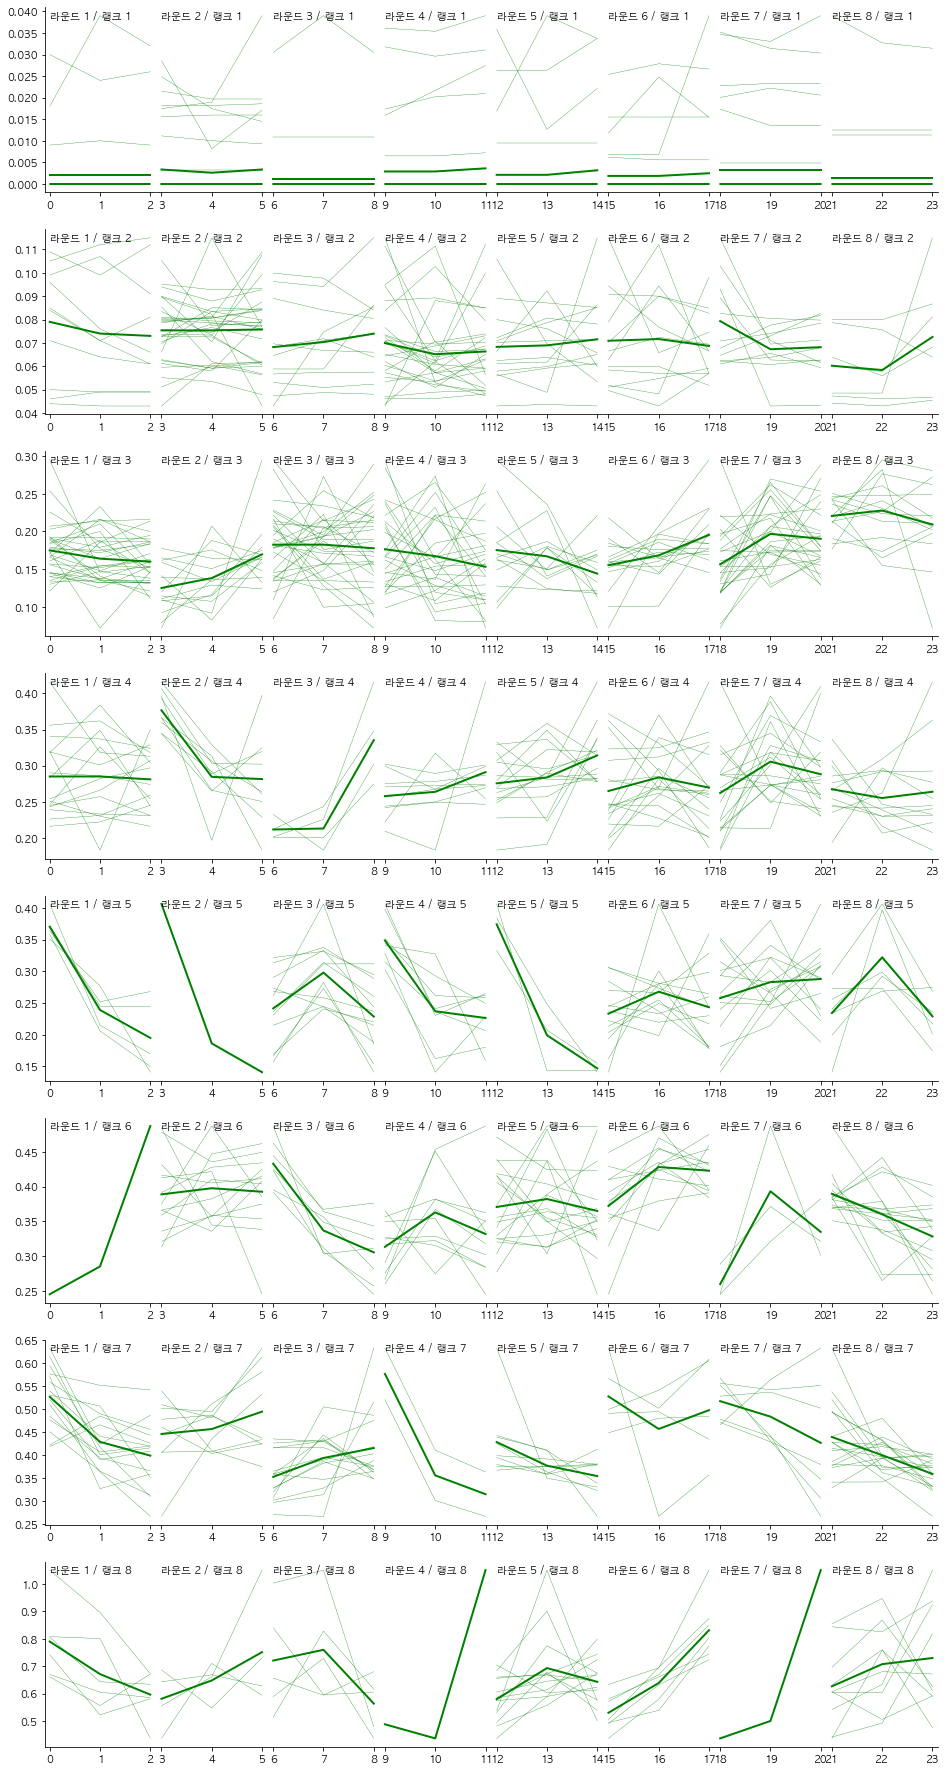

In [1186]:
visualization(24)

# Contribution Map

In [1187]:
contribution_df = calc_contribution_rank(hc, ci)
contribution_df.index = df.index[::size] 

contribution_df.head()

,아파트1-101-104,아파트1-101-1302,아파트1-101-1502,아파트1-101-1604,아파트1-102-1402,아파트1-102-303,아파트1-102-802,아파트1-102-901,아파트1-102-903,아파트1-103-1002,...,아파트4-103-703,아파트4-103-708,아파트4-103-805,아파트4-103-902,아파트4-103-906,아파트4-103-909,아파트4-104-1501,아파트4-105-103,아파트4-105-601,아파트4-105-803
2018-05-01 00:00:00,5.0,8.0,2.0,3.0,5.0,3.0,8.0,5.0,7.0,7.0,...,3.0,8.0,5.0,5.0,7.0,5.0,3.0,5.0,3.0,5.0
2018-05-01 03:00:00,4.0,6.0,2.0,4.0,6.0,4.0,7.0,2.0,7.0,7.0,...,4.0,7.0,6.0,6.0,4.0,4.0,4.0,4.0,4.0,6.0
2018-05-01 06:00:00,7.0,6.0,3.0,3.0,7.0,5.0,6.0,2.0,7.0,7.0,...,3.0,7.0,5.0,7.0,7.0,5.0,5.0,7.0,5.0,5.0
2018-05-01 09:00:00,7.0,3.0,3.0,3.0,5.0,5.0,6.0,2.0,3.0,6.0,...,3.0,5.0,6.0,6.0,3.0,3.0,2.0,8.0,3.0,3.0
2018-05-01 12:00:00,8.0,6.0,4.0,4.0,8.0,7.0,6.0,6.0,6.0,7.0,...,4.0,8.0,8.0,8.0,6.0,4.0,6.0,7.0,4.0,3.0


# Problem 1. 총 사용량이 많지만, 최종 기여도가 낮은 가구의 존재 (Anomaly)
- 특정 요일에 전기를 워낙 적게 써서 나타난 현상으로, 해당의 경우에는 총사용량을 토대로 해당 이상치로 판단되는 가구가 현재의 그룹에 어울리는지 다음 랭크 기여도 그룹에 어울리는 지를 판단한다.
- 이는 기여도 산출에 rank 방식을 이용한 이유였다. 클러스터링 percentage 방식으로 기여도를 적용할 경우, 총 사용량이 높은 가구가 특정 요일에 percentage가 워낙 적게 나와 마지막 기여도 종합 단계에서 문제를 보여줬었다. 아래의 함수로 이러한 이상치들을 제거해준다.

### 1. Remove Anomaly

In [1188]:
cont_mean_df = remove_anomaly(df, contribution_df)

cont_mean_df.head()

,contribution
아파트1-101-104,6.0
아파트1-101-1302,7.0
아파트1-101-1502,4.0
아파트1-101-1604,3.0
아파트1-102-1402,6.0


- 이상치가 제거된 형태의 최종 기여도

In [1189]:
print("{} ~ {} 까지의 기여도 그룹이 만들어졌다.".format(
    cont_mean_df['contribution'].min(), cont_mean_df['contribution'].max()))
cont_count = pd.DataFrame(
    cont_mean_df['contribution'].groupby(cont_mean_df['contribution']).count()
)
cont_count.columns = ['그룹 멤버 수']
cont_count

1.0 ~ 7.0 까지의 기여도 그룹이 만들어졌다.


,그룹 멤버 수
contribution,
1.0,31
2.0,12
3.0,14
4.0,32
5.0,6
6.0,10
7.0,15


# 대표 클러스터링 패턴 선정
- 각 기여도 그룹의 가구들은 n시간 마다 특정 군집에 속해있었다.
- 특정 기여도 그룹의 n개의 시간대의 대표 클러스터링 패턴 선정은 해당 그룹의 멤버들이 가장 많이 속해 있었던 클러스터링으로 선정을 하겠다.

In [1190]:
# Cluster by Contribution GroupBy
cc = pd.DataFrame()
cont_group = set(cont_mean_df.values.flatten())

for group in cont_group:
    group_cols = cont_mean_df[cont_mean_df['contribution'] == group].index
    _hc = hc[group_cols].T.copy()
    _clusters = np.array([])
    
    for idx in range(0, len(hc)):
        _group = _hc[idx].groupby(_hc[idx]).count()
        max_cluster = _group.argmax()

        _clusters = np.append(_clusters,
                              _group.keys()[max_cluster])
    
    cc["기여도 그룹 {}".format(int(group))] = _clusters
    
cc.head()

,기여도 그룹 1,기여도 그룹 2,기여도 그룹 3,기여도 그룹 4,기여도 그룹 5,기여도 그룹 6,기여도 그룹 7
0,1.0,1.0,7.0,7.0,4.0,2.0,2.0
1,0.0,0.0,3.0,3.0,3.0,2.0,1.0
2,5.0,4.0,3.0,3.0,7.0,0.0,0.0
3,1.0,1.0,6.0,0.0,0.0,3.0,4.0
4,5.0,5.0,7.0,4.0,2.0,0.0,0.0


## 선정된 대표 클러스터링의 패턴 파싱하기

In [1191]:
cc_cols = cc.columns
_cc_pattern = np.array([])

for cc_col in cc_cols:
    _cc = cc[cc_col]
    for division_round, _cc in enumerate(_cc):
        _round_pattern = ci[division_round][0][int(_cc)]
        
        _cc_pattern = np.append(_cc_pattern,_round_pattern)
        
cc_pattern = pd.DataFrame(_cc_pattern.reshape(-1,len(cc) * 3),
                         index=cc_cols,
                         columns=df.index).T
cc_pattern.head()

,기여도 그룹 1,기여도 그룹 2,기여도 그룹 3,기여도 그룹 4,기여도 그룹 5,기여도 그룹 6,기여도 그룹 7
2018-05-01 00:00:00,0.002,0.002,0.175,0.175,0.285,0.527,0.527
2018-05-01 01:00:00,0.002,0.002,0.164,0.164,0.285,0.429,0.429
2018-05-01 02:00:00,0.002,0.002,0.160,0.160,0.281,0.399,0.399
2018-05-01 03:00:00,0.009,0.009,0.141,0.141,0.141,0.197,0.422
2018-05-01 04:00:00,0.007,0.007,0.141,0.141,0.141,0.217,0.429


# 시각화

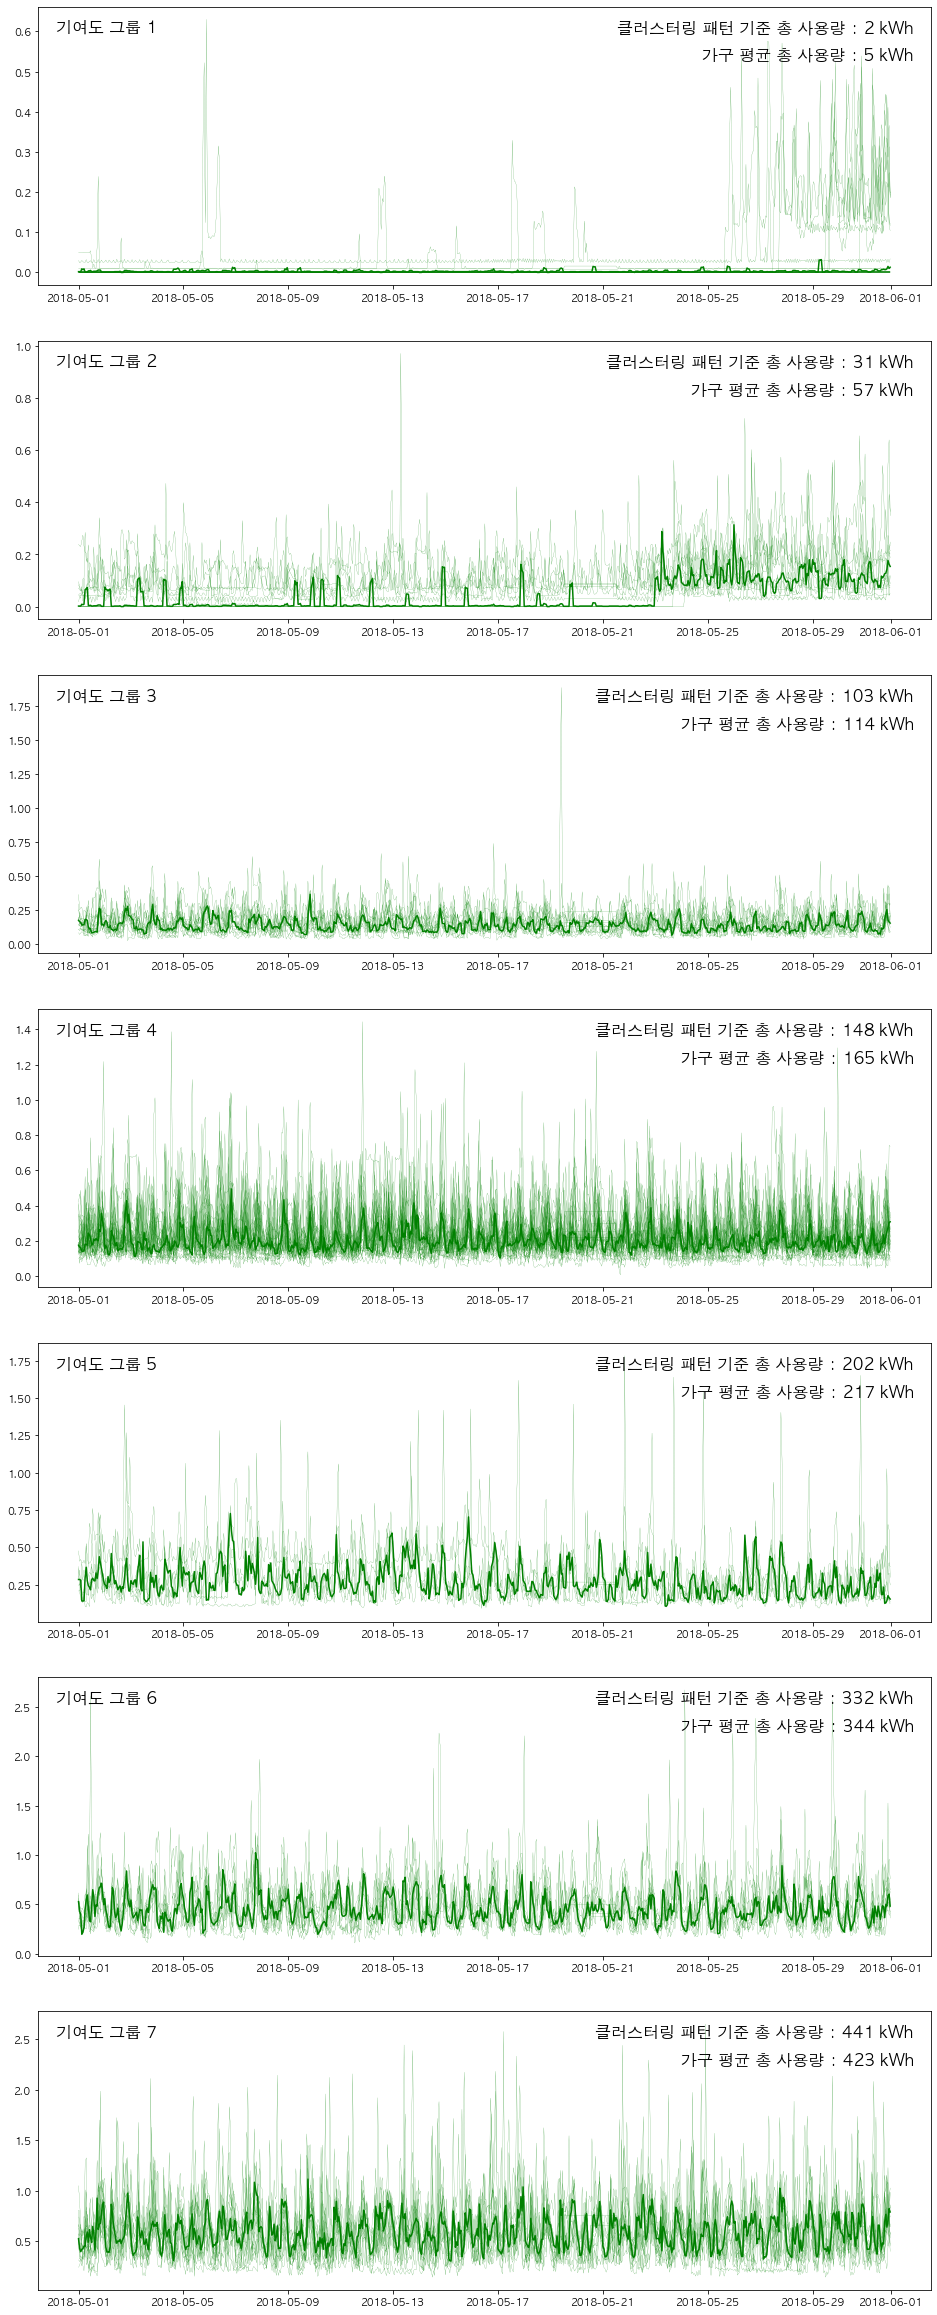

In [1192]:
fig, ax = plt.subplots(len(cc_cols),1, figsize=(16, 6 * len(cc_cols)))

for group_idx,group in enumerate(cont_group):
    cols = df.columns
    _group_cols = cols[(cont_mean_df['contribution'] == group).values]

    ax[group_idx].plot(df[_group_cols], linewidth=0.15, color='g')
    ax[group_idx].plot(cc_pattern[cc_cols[group_idx]], linewidth=1.5, color='g')
    ax[group_idx].text(0.02, 0.925, cc_cols[group_idx], 
                       ha='left', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    ax[group_idx].text(0.98, 0.925, "클러스터링 패턴 기준 총 사용량 : {} kWh".format(round(cc_pattern[cc_cols[group_idx]].sum())), 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    ax[group_idx].text(0.98, 0.825, "가구 평균 총 사용량 : {} kWh".format(round(df[_group_cols].sum().mean())), 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)

plt.show()

# 기여도 산정 방식

## 그룹 == 랭크
- 각 그룹의 번호는 랭크를 나타내기도 한다. 이를 통해 그대로 선정해도 된다.

In [1193]:
ranks = np.array(list(cont_group))
["{}%".format(int(_)) for _ in (ranks / ranks.sum() * 100).round()]

['4%', '7%', '11%', '14%', '18%', '21%', '25%']

## 클러스터링 패턴 기준 총 사용량
- 위에서 파싱한 클러스터링 패턴을 기여도로 이용해도 된다.
- 전체 기여도 (100 == 모든 클러스터링 패턴)

In [1194]:
(((cc_pattern.sum() / cc_pattern.sum().sum()) * 100).round()).map(lambda x: "{}%".format(int(x)))

기여도 그룹 1     0%
기여도 그룹 2     2%
기여도 그룹 3     8%
기여도 그룹 4    12%
기여도 그룹 5    16%
기여도 그룹 6    26%
기여도 그룹 7    35%
dtype: object

# 분산을 구해봅시다

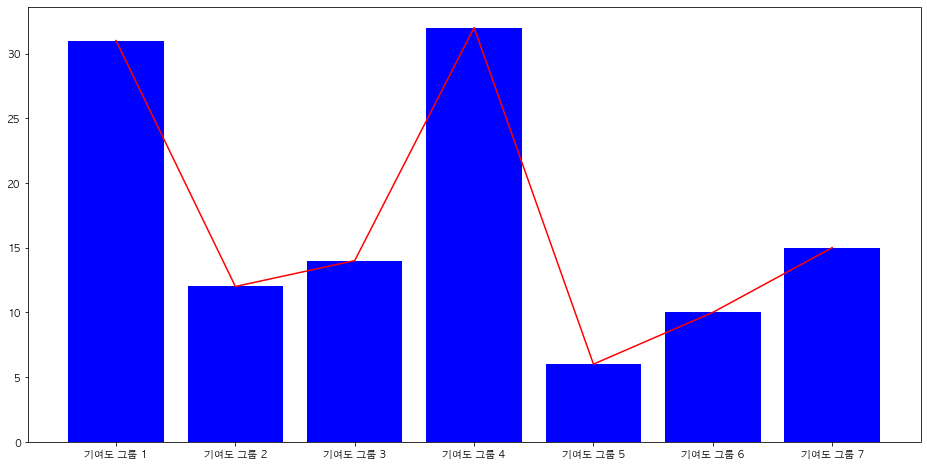

In [1195]:
plt.figure(figsize=(16,8))
_plots = list()

for rank in ranks:
    plt.bar(cc_cols[int(rank) - 1], len(cont_mean_df[cont_mean_df['contribution'] == rank]), color='b')
    _plots.append(len(cont_mean_df[cont_mean_df['contribution'] == rank]))

plt.plot(_plots, color='r')
plt.show()

# 가격분배
- 이전에 공동설비사용요금은 각 가구들에게 요금 산정이 이루어진 후의 나머지 요금인데 이는 특정 누진구간부터 시작된 가격과 비슷하다는 것을 말한적이 있었다.
- 그리고 가구 수 만큼 다시 곱해지는 현상이 있었다.
- 각 가구들은 특정 기여도그룹에 속했고, 해당 기여도의 percentage를 구했었다.
- 가구 별로 부여받은(기여도그룹의 기여도) 기여도를 이용해서 처음에 기여도 요금표 (사용량에 영향을 미치는 기본요금과 전력량 요금)를 만든 후, 그 다음에 나머지를 n분의 1로 부여받는 식으로 해당 프로세스를 이어간다.

In [1196]:
month_df = pd.DataFrame(df.sum().round().astype("int"))
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']
month_df.head()

,name,usage (kWh)
0,아파트1-101-104,357
1,아파트1-101-1302,414
2,아파트1-101-1502,156
3,아파트1-101-1604,122
4,아파트1-102-1402,335


# 본격 시작점

In [1214]:
PUBLIC_PERCENTAGE = 30
month = df.index[0].month
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

print("아파트 정보")
print("- 세대부 사용량 : {}kWh".format(format(households_kWh, ",")))
print("- 공용부 사용량 : {}kWh\n".format(format(APT - households_kWh, ",")))

# 단일계약
single_calc = crs.models.ManagementOffice(
    month=month,
    households=month_df,
    APT=APT,
    contract="단일계약"
)


bill_df = pd.DataFrame([[hh.name, hh.bill, hh.public_fee] for hh in single_calc.households],
                       columns=["name", "최종청구금액", "공동설비요금"])
bill_df.set_index("name", inplace=True)

print("요금 정보")
print("- 공동설비사용요금 : {}원".format(format(bill_df['공동설비요금'].sum(), ",")))

bill_df.head()

아파트 정보
- 세대부 사용량 : 18,782kWh
- 공용부 사용량 : 8,049kWh

요금 정보
- 공동설비사용요금 : 683,040원


,최종청구금액,공동설비요금
name,,
아파트1-101-104,50122,5692
아파트1-101-1302,66032,5692
아파트1-101-1502,17082,5692
아파트1-101-1604,14152,5692
아파트1-102-1402,46502,5692


In [1215]:
fee = None
if (month >= 1 and month <= 6) or\
    (month >= 9 and month <= 12):
    fee = crs.common.contract.high_pressure_fee
else:
    fee = crs.common.contract.high_pressure_fee_summer
    
fee

[[0, 200, 730, 73.3], [201, 400, 1260, 142.3], [400, inf, 6060, 210.6]]

In [1216]:
# 공동설비 시작 누진단계 구하기
mean_kwh = round(APT / len(bill_df))
apply_households = round(mean_kwh * ((100 - PUBLIC_PERCENTAGE) / 100))
apply_public = round(mean_kwh * ((PUBLIC_PERCENTAGE) / 100))

print("아파트 정보 (단일계약 요금산정 전력량)")
print("- 전체 사용량 : {}kWh".format(format(mean_kwh, ",")))
print("- 세대부 사용량 : {}kWh".format(format(apply_households, ",")))
print("- 공용부 사용량 : {}kWh\n".format(format(apply_public, ",")))

# 공동설비 시작 누진단계
public_step = 0
remain = 0

households_nugin_step = 1
for step, _f in enumerate(fee):
    if (_f[1] > apply_households):
        public_step = step
        err = _f[1] - apply_households
        remain = apply_public if step == 2 else apply_public if err > apply_public else err
        
        print("공동설비 시작 누진단계 : {}단계".format(public_step + 1))
        print("해당 단계 나머지 : {}kWh".format(format(remain)))
        break
        
print("단계 {}부터 시작되는 기여도 요금 산정에 들어갑니다.".format(public_step + 1))

아파트 정보 (단일계약 요금산정 전력량)
- 전체 사용량 : 224kWh
- 세대부 사용량 : 157kWh
- 공용부 사용량 : 67kWh

공동설비 시작 누진단계 : 1단계
해당 단계 나머지 : 43kWh
단계 1부터 시작되는 기여도 요금 산정에 들어갑니다.


In [1217]:
# #  기본요금
cont_fee = fee[public_step:]
public_fees = list()
tmp_public = apply_public
step = 0
while True:
    if cont_fee[step][1] == float('inf'):
        public_fees.append(
            tmp_public * cont_fee[step][3]
        )
        break
    else:
        if step == 0:
            public_fees.append(
                (remain * cont_fee[step][3]) + (cont_fee[step][2] * (remain / apply_public))
            )
            tmp_public -= remain
            remain = 0
        else:
            err = cont_fee[step][1] - cont_fee[step - 1][1]
            if err > tmp_public:
                public_fees.append(
                    tmp_public * cont_fee[step][3] + (cont_fee[step][2] * (tmp_public / apply_public))
                )
                break
            else:
                public_fees.append(
                    err * cont_fee[step][3] + (cont_fee[step][2] * (err / apply_public))
                )
                tmp_public -= err
                
    if tmp_public <= 0:
        break
        
    step += 1
    
public_fees = np.array(public_fees)
public_fees

array([3620.40746269, 3866.54328358])

In [1218]:
# cont_fee = fee[public_step:]
# public_fees = list()
# tmp_public = apply_public
# step = 0
# while True:
#     if cont_fee[step][1] == float('inf'):
#         public_fees.append(
#             tmp_public * cont_fee[step][3]
#         )
#         break
#     else:
#         if step == 0:
#             public_fees.append(
#                 (remain * cont_fee[step][3])
#             )
#             tmp_public -= remain
#             remain = 0
#         else:
#             err = cont_fee[step][1] - cont_fee[step - 1][1]
#             if err > tmp_public:
#                 public_fees.append(
#                     tmp_public * cont_fee[step][3]
#                 )
#                 break
#             else:
#                 public_fees.append(
#                     err * cont_fee[step][3]
#                 )
#                 tmp_public -= err
                
#     if tmp_public <= 0:
#         break
        
#     step += 1
    
# public_fees = np.array(public_fees)
public_fees

array([3620.40746269, 3866.54328358])

In [1219]:
contribution_cluster = (((cc_pattern.sum() / cc_pattern.sum().sum()) * 100).round())

print("다음과 같은 형태로 요금이 산정됩니다.")
_group_cont_rate = (public_fees.sum() * (contribution_cluster / 100)).round().values
(public_fees.sum() * (contribution_cluster / 100)).round()

다음과 같은 형태로 요금이 산정됩니다.


기여도 그룹 1       0.0
기여도 그룹 2     150.0
기여도 그룹 3     599.0
기여도 그룹 4     898.0
기여도 그룹 5    1198.0
기여도 그룹 6    1947.0
기여도 그룹 7    2620.0
dtype: float64

In [1220]:
cont_rate = cont_mean_df.copy() 
cont_rate['기여도 산정 공동설비사용요금'] = cont_mean_df['contribution'].map(lambda x: _group_cont_rate[int(x) - 1]).astype("int")

public_total = bill_df['공동설비요금'].sum()
total_cont_rate = cont_rate['기여도 산정 공동설비사용요금'].sum()

print("요금 정보")
print("- 공동설비사용요금 : {}원".format(format(bill_df['공동설비요금'].sum(), ",")))
print("- 기여도 산정 공동설비사용요금 : {}원".format(format(total_cont_rate, ",")))
print("- 나머지 : {}원".format(format(public_total - total_cont_rate, ",")))

cont_rate['나머지 재분배'] = round((public_total - total_cont_rate) / len(cont_rate))
cont_rate

요금 정보
- 공동설비사용요금 : 683,040원
- 기여도 산정 공동설비사용요금 : 104,880원
- 나머지 : 578,160원


,contribution,기여도 산정 공동설비사용요금,나머지 재분배
아파트1-101-104,6.0,1947,4818
아파트1-101-1302,7.0,2620,4818
아파트1-101-1502,4.0,898,4818
아파트1-101-1604,3.0,599,4818
아파트1-102-1402,6.0,1947,4818
...,...,...,...
아파트4-103-909,5.0,1198,4818
아파트4-104-1501,4.0,898,4818
아파트4-105-103,6.0,1947,4818
아파트4-105-601,4.0,898,4818


# 재분배

In [1221]:
bill_df['기여도 산정 공동설비사용요금'] = cont_rate['나머지 재분배'] + cont_rate['기여도 산정 공동설비사용요금']

bill_df['재분배 최종청구금액'] = bill_df['최종청구금액'] - bill_df['공동설비요금'] + bill_df['기여도 산정 공동설비사용요금']
bill_df.head()

,최종청구금액,공동설비요금,기여도 산정 공동설비사용요금,재분배 최종청구금액
name,,,,
아파트1-101-104,50122,5692,6765,51195
아파트1-101-1302,66032,5692,7438,67778
아파트1-101-1502,17082,5692,5716,17106
아파트1-101-1604,14152,5692,5417,13877
아파트1-102-1402,46502,5692,6765,47575


# CRS 비교

In [ ]:
p,m = crs.utils.data_preprocessing(xlsx)

m.head()

In [ ]:
# 3. bill - calc
min_per = PUBLIC_PERCENTAGE
max_per = PUBLIC_PERCENTAGE + 5
bc_result = crs.utils.bill_calc(m, p, min_per, max_per)

In [ ]:
# 일반분석
na_result = crs.utils.normal_analysis(bc_result)

In [ ]:
month = df.index[0].month

positive_count_per = PUBLIC_PERCENTAGE

comp_public_bill = int(bc_result['public_bill']['comp'].loc[month][str(positive_count_per)])
single_public_bill = int(bc_result['public_bill']['single'].loc[month][str(positive_count_per)])

comp_pos_cnt = int(na_result['positive_count']['comp'].loc[month][str(positive_count_per)])
single_pos_cnt = int(na_result['positive_count']['single'].loc[month][str(positive_count_per)])

print("공동설비사용량 {}% 지점의 정보 {} : {}".format(positive_count_per, comp_pos_cnt, single_pos_cnt))
print("• 종합계약 공동설비사용요금 : {}원".format(format(comp_public_bill, ",")))
print("   • 1인당 지불해야 하는 요금 : {}원".format(format(round(comp_public_bill / len(df.columns)), ",")))
print("• 단일계약 공동설비사용요금 : {}원".format(format(single_public_bill, ",")))
print("   • 1인당 지불해야 하는 요금 : {}원".format(format(round(single_public_bill / len(df.columns)), ",")))

In [ ]:
comp_bill = bc_result['households_bill']['comp'][month - 1]
single_bill = bc_result['households_bill']['single'][month - 1]

bill_cols = comp_bill.columns

pos_comp_cols = bill_cols[comp_bill.loc[positive_count_per] < single_bill.loc[positive_count_per]]
pos_single_cols = bill_cols[comp_bill.loc[positive_count_per] > single_bill.loc[positive_count_per]]

In [ ]:
comp_cont_df = cont_mean_df.loc[pos_comp_cols]
single_cont_df = cont_mean_df.loc[pos_single_cols]

print("종합계약 유리 가구 수 기여도 그룹 : {}".format(set(comp_cont_df['contribution'])))
print("단일계약 유리 가구 수 기여도 그룹 : {}".format(set(single_cont_df['contribution'])))

fig, ax = plt.subplots(len(cc_cols),1, figsize=(16, 6 * len(cc_cols)))

for group_idx,group in enumerate(cont_group):
    cols = df.columns
    _group_cols = cols[(cont_mean_df['contribution'] == group).values]
    _comp_win_cnt = 0
    
    for _c in _group_cols:
        ax[group_idx].plot(df[_c], linewidth=0.3, color="r" if _c in pos_comp_cols else "b", alpha=0.5,
                          label="종합계약 유리 가구" if _c in pos_comp_cols else "단일계약 유리 가구")
        if _c in pos_comp_cols:
            _comp_win_cnt += 1
            
    err_bill = single_bill[_group_cols].loc[positive_count_per].sum() - comp_bill[_group_cols].loc[positive_count_per].sum()
        
    ax[group_idx].plot(
        cc_pattern[cc_cols[group_idx]], linewidth=1.5, color='r' if _comp_win_cnt == len(_group_cols) else 'lime')
    ax[group_idx].text(0.015, 0.925, "{} (가구 수: {})".format(cc_cols[group_idx], len(_group_cols)), 
                       ha='left', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    ax[group_idx].text(0.985, 0.925, "{} kWh".format(round(cc_pattern[cc_cols[group_idx]].sum())), 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    
    err_text = ""
    if abs(err_bill) > 0:
        if err_bill > 0:
            err_text = "손해 : {}원".format(
                format(int(err_bill), ","))
        else:
            err_text = "이익 : {}원".format(
                format(int(abs(err_bill)), ","))
        
    ax[group_idx].text(0.985, 0.825, err_text, 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)

plt.show()

## 재분배를 통해 단일계약이 다시 유리해진 가구 확인

In [1211]:
single_bill.loc[positive_count_per] = bill_df['재분배 최종청구금액']

In [1212]:
pos_comp_cols = bill_cols[comp_bill.loc[positive_count_per] < single_bill.loc[positive_count_per]]
pos_single_cols = bill_cols[comp_bill.loc[positive_count_per] > single_bill.loc[positive_count_per]]

print("공동설비사용량 {}% 지점의 정보 {} : {}".format(positive_count_per, len(pos_comp_cols), len(pos_single_cols)))

공동설비사용량 10% 지점의 정보 0 : 120


종합계약 유리 가구 수 기여도 그룹 : set()
단일계약 유리 가구 수 기여도 그룹 : {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


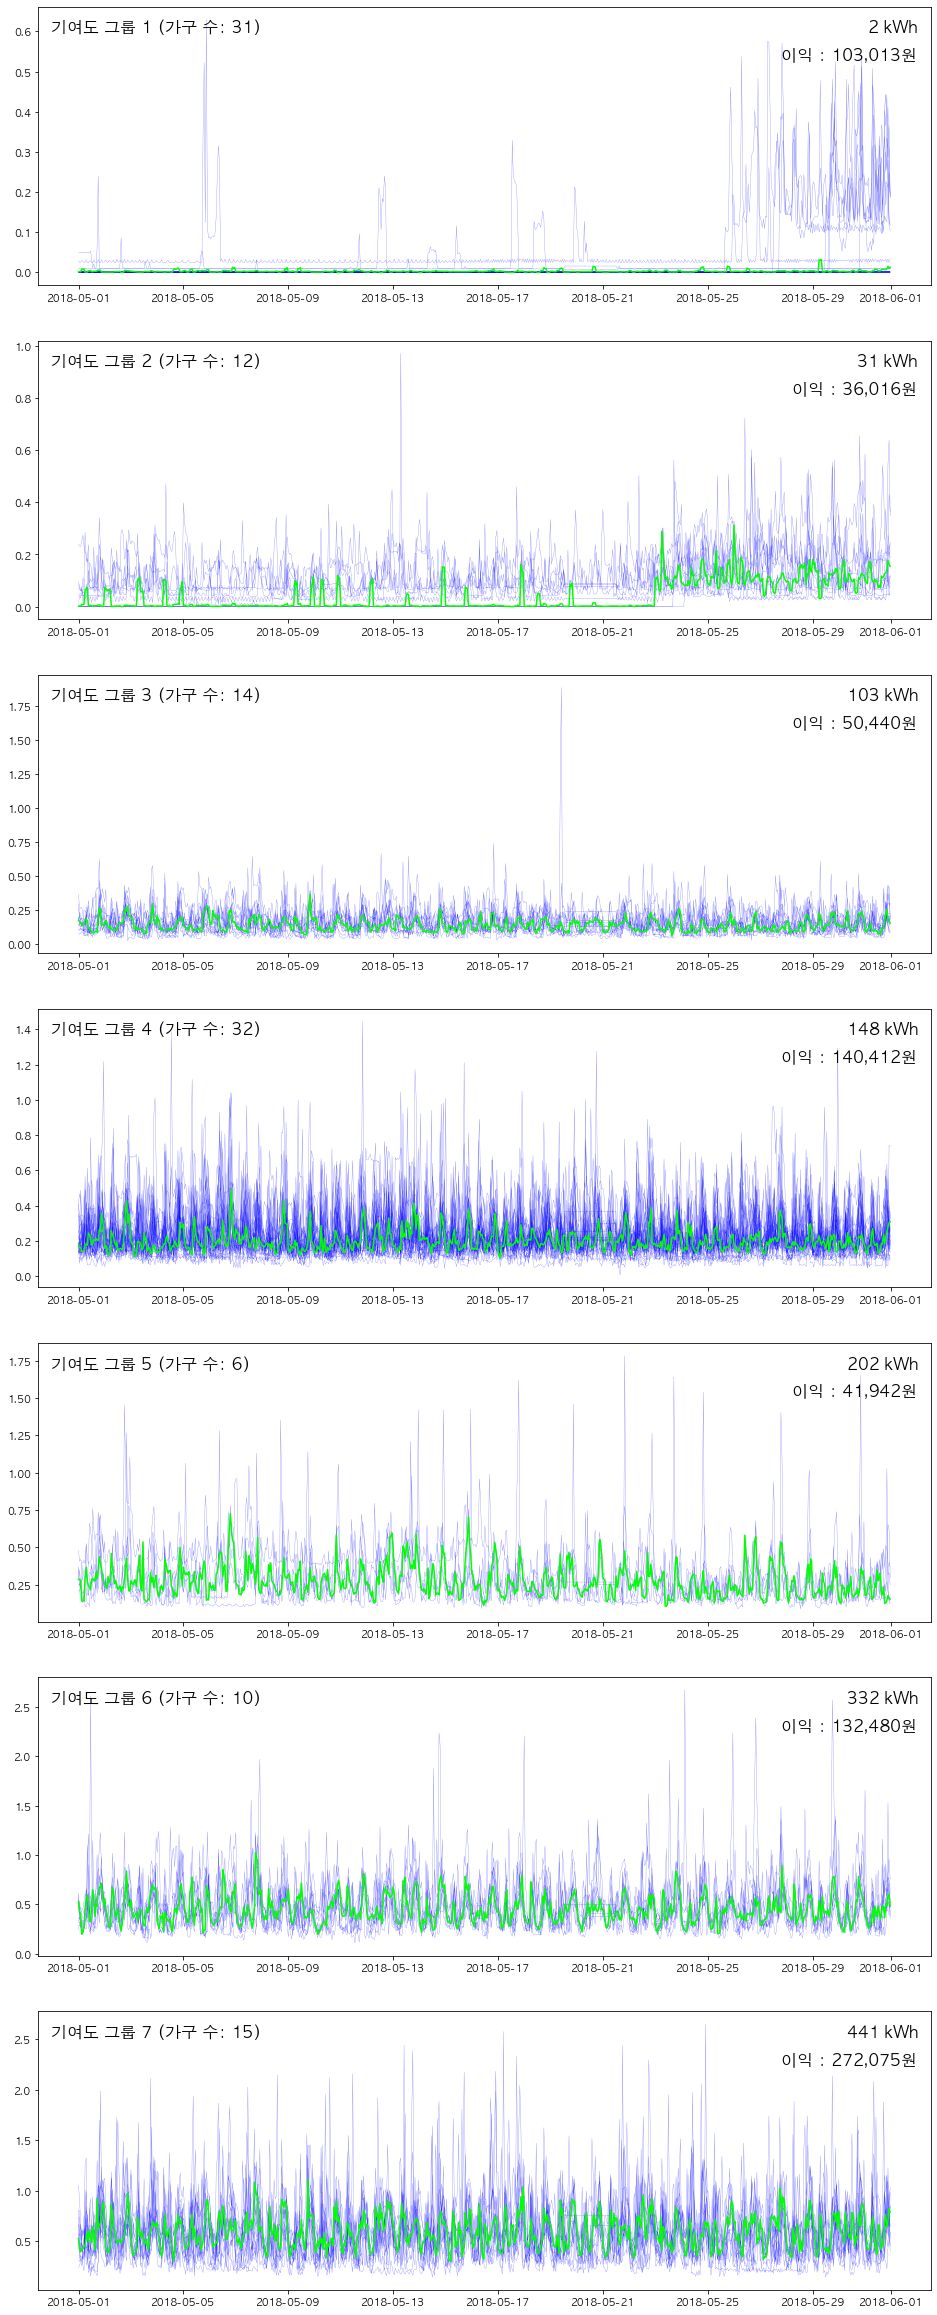

In [1213]:
comp_cont_df = cont_mean_df.loc[pos_comp_cols]
single_cont_df = cont_mean_df.loc[pos_single_cols]

print("종합계약 유리 가구 수 기여도 그룹 : {}".format(set(comp_cont_df['contribution'])))
print("단일계약 유리 가구 수 기여도 그룹 : {}".format(set(single_cont_df['contribution'])))

fig, ax = plt.subplots(len(cc_cols),1, figsize=(16, 6 * len(cc_cols)))

for group_idx,group in enumerate(cont_group):
    cols = df.columns
    _group_cols = cols[(cont_mean_df['contribution'] == group).values]
    _comp_win_cnt = 0
    
    for _c in _group_cols:
        ax[group_idx].plot(df[_c], linewidth=0.3, color="r" if _c in pos_comp_cols else "b", alpha=0.5,
                          label="종합계약 유리 가구" if _c in pos_comp_cols else "단일계약 유리 가구")
        if _c in pos_comp_cols:
            _comp_win_cnt += 1
            
    err_bill = single_bill[_group_cols].loc[positive_count_per].sum() - comp_bill[_group_cols].loc[positive_count_per].sum()
        
    ax[group_idx].plot(
        cc_pattern[cc_cols[group_idx]], linewidth=1.5, color='r' if _comp_win_cnt == len(_group_cols) else 'lime')
    ax[group_idx].text(0.015, 0.925, "{} (가구 수: {})".format(cc_cols[group_idx], len(_group_cols)), 
                       ha='left', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    ax[group_idx].text(0.985, 0.925, "{} kWh".format(round(cc_pattern[cc_cols[group_idx]].sum())), 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    
    err_text = ""
    if abs(err_bill) > 0:
        if err_bill > 0:
            err_text = "손해 : {}원".format(
                format(int(err_bill), ","))
        else:
            err_text = "이익 : {}원".format(
                format(int(abs(err_bill)), ","))
        
    ax[group_idx].text(0.985, 0.825, err_text, 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)

plt.show()

# 피드백 서비스

## 요일 피드백

## 시간 피드백